# Prophet 
HDD y CDD como variables predictoras

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

from data   import train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

C:\Users\flavi\anaconda3\envs\time-series\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\flavi\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\flavi\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Setup

In [4]:
DATASET_PATH = 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.rename(columns={'dia':'ds','mwh':'y'},inplace=True)

dataset.head()

,ds,y,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


### HDD and CDD indices

Heating/Cooling Degree Days measure the amount of heating or cooling necessary at your property. Degree days are measured relative to a base of 65°F (18°C). Above 18°C it is assumed that your property will need to have cooling, and below 18°C it is assumed that your property will need to have heating.

The bases to terminate whether a specific day is a heating degree day or a cooling degree day is the daily average temperature TM (add the high and low temperatures and divide it by two). Each day with a mean temperature below 18°C is counted as one heating degree day. The cooling degree day is the summer counterpart of the heating degree day.

Heating degree days are calculated over a period of time by adding up the differences between each day's mean daily temperature and the temperature of 18°C (or 65°F). For any temperature above 18°C the building is assumed not to need any heating. For example three winter days in a row with average temperatures of 4°C, -2°C and -4°C totals to 56 HDD. Accordingly, three summer days of 26°C, 28°C, and 30°C totals to 30 CDD.

Referencia general:
https://www.weatheronline.co.uk/faq/hdd_cdd.html

otras ref: https://www.e-education.psu.edu/egee102/node/2055

https://energystar-mesa.force.com/PortfolioManager/s/article/What-are-Heating-Degree-Days-HDD-Cooling-Degree-Days-CDD-1600088536891

Elijo 18°C. Se pueden probar otros valores.

In [5]:
t_base=18

In [6]:
dataset['CDD']=dataset['tmp'].apply(lambda x: x - t_base if x >t_base else 0)
dataset['HDD']=dataset['tmp'].apply(lambda x: t_base - x if x <t_base else 0)

In [7]:
#dataset.rename(columns={'ds':'dia','y':'MWh','tmp':'TMP'},inplace=True)
#dataset.to_csv('consumo_energetico_diario_hdd_cdd.csv', index=False)

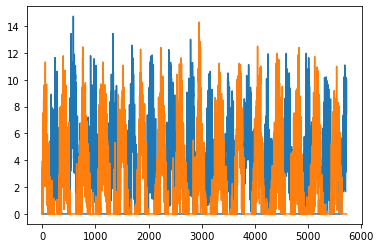

In [8]:
plt.plot(dataset.HDD)
plt.plot(dataset.CDD)

## Functions

In [9]:
def predict(model, y_true_df, times):
    sns.set(rc = {'figure.figsize':(10,6)})

    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    model.plot(y_pred_df)

## Preprocessing

In [10]:
train_set, test_set = train_test_split(dataset,0.10095)
N_test=len(test_set)

Acoto desde 2012 en adelante ya que las oscilaciones se ven de amplitud mas constante. Al observar los años 2006-2011 parecen ir creciendo la tendencia de consumo de energía.

In [11]:
train_set=train_set[train_set.ds>'12-31-2011'] #ultimo dia train 31/12/2019
train_set.reset_index(inplace=True)

## Model

In [12]:
model = Prophet() #mcmc_samples=300 #full bayesian
#model.add_regressor('tmp',mode='additive')

model.add_regressor('HDD',mode='additive')
model.add_regressor('CDD',mode='additive')
#model.add_country_holidays(country_name='Argentina')

model.fit(train_set)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [13]:
#model.train_holiday_names

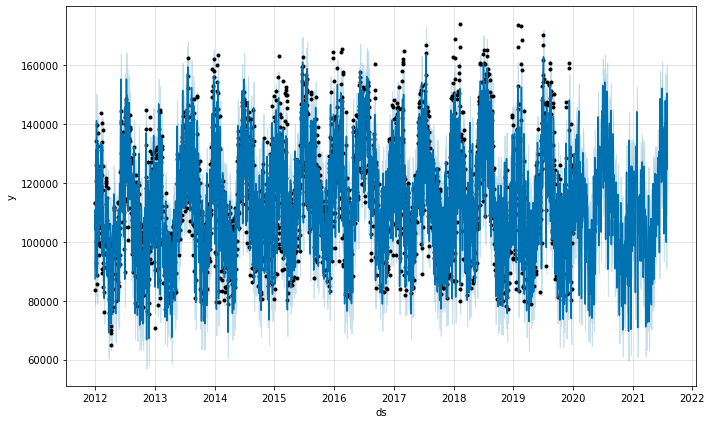

In [14]:
dataset_periodo=dataset[dataset.ds>'12-31-2011']
dataset_periodo.reset_index(inplace=True)

future = model.make_future_dataframe(periods=N_test)
future['HDD']=dataset_periodo.HDD
future['CDD']=dataset_periodo.CDD
#future['tmp']=dataset_periodo.tmp

forecast = model.predict(future)
fig=model.plot(forecast)

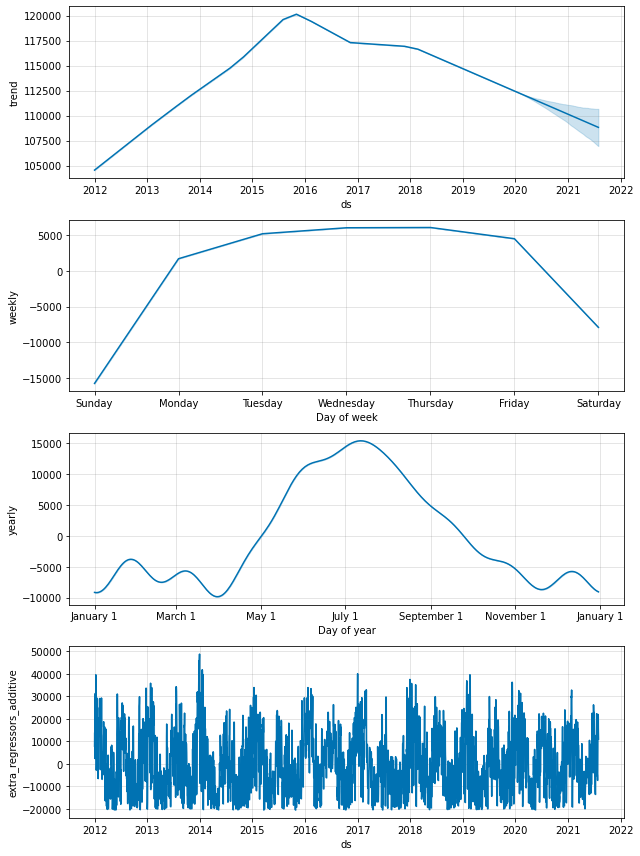

In [15]:
fig=model.plot_components(forecast)

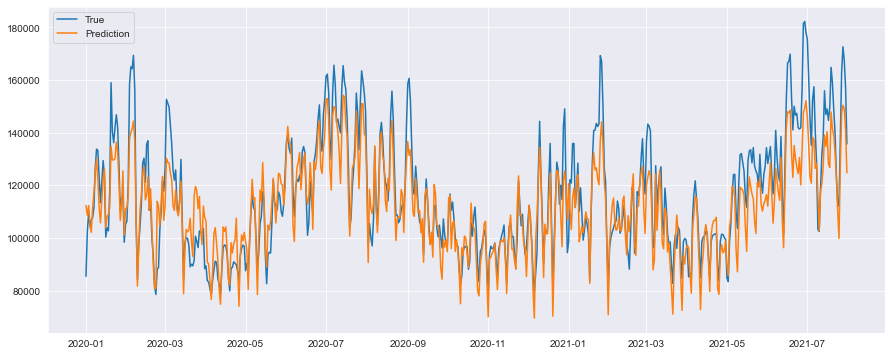

In [16]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.ds,test_set.y,label="True")
plt.plot(test_set.ds,y_fore_future, label="Prediction")
plt.legend()

In [17]:
mse = mean_squared_error(train_set.y, y_fore_train)
mae = mean_absolute_error(train_set.y, y_fore_train)
mape = mean_absolute_percentage_error(train_set.y, y_fore_train)
print('Train - Error cuadratico medio: ', mse)
print('Train - Error absoluto medio: ',mae)
print('Train - Error porcentual abs:',mape)

mse = mean_squared_error(test_set.y, y_fore_future)
mae = mean_absolute_error(test_set.y, y_fore_future)
mape = mean_absolute_percentage_error(test_set.y, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

Train - Error cuadratico medio:  51569845.650048904
Train - Error absoluto medio:  5493.471505378161
Train - Error porcentual abs: 0.04941071358762632
Test - Error cuadratico medio:  106493295.68535511
Test - Error absoluto medio:  8063.276229687415
Test - Error porcentual abs: 0.06741744045473469


In [18]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               3500 non-null   datetime64[ns]
 1   trend                            3500 non-null   float64       
 2   yhat_lower                       3500 non-null   float64       
 3   yhat_upper                       3500 non-null   float64       
 4   trend_lower                      3500 non-null   float64       
 5   trend_upper                      3500 non-null   float64       
 6   CDD                              3500 non-null   float64       
 7   CDD_lower                        3500 non-null   float64       
 8   CDD_upper                        3500 non-null   float64       
 9   HDD                              3500 non-null   float64       
 10  HDD_lower                        3500 non-null   float64    

In [19]:
model = Prophet() #mcmc_samples=300 #full bayesian
model.add_regressor('tmp',mode='additive')

#model.add_regressor('HDD',mode='additive')
#model.add_regressor('CDD',mode='additive')
#model.add_country_holidays(country_name='Argentina')

model.fit(train_set)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


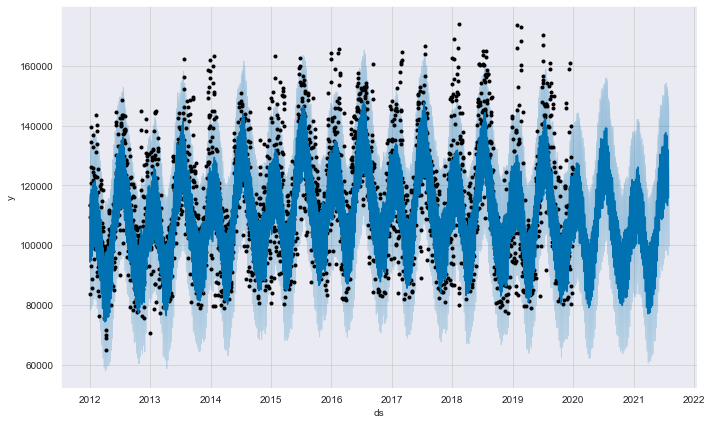

In [21]:
dataset_periodo=dataset[dataset.ds>'12-31-2011']
dataset_periodo.reset_index(inplace=True)

future = model.make_future_dataframe(periods=N_test)
#future['HDD']=dataset_periodo.HDD
#future['CDD']=dataset_periodo.CDD
future['tmp']=dataset_periodo.tmp

forecast = model.predict(future)
fig=model.plot(forecast)

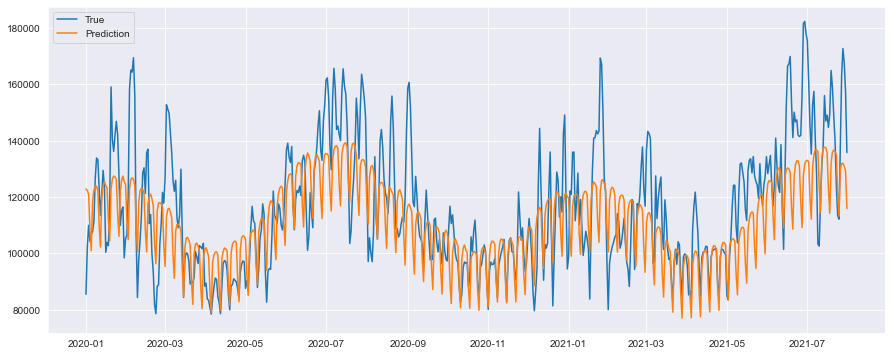

In [22]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.ds,test_set.y,label="True")
plt.plot(test_set.ds,y_fore_future, label="Prediction")
plt.legend()